**<h1>Importing Libraries</h1>**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import kagglehub
import missingno as msno
import seaborn as sns
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
import requests
import zipfile
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

**<h1>Loading Dataset</h1>**
For our analysis, we only need 'overall_rating', 'headline', 'pros', 'cons' and 'firm', so the other columns are dropped.

In [ ]:
path = kagglehub.dataset_download("davidgauthier/glassdoor-job-reviews")
print("Path to dataset files:", path)
data = pd.read_csv(path + "/glassdoor_reviews.csv", sep=',', encoding='latin-1')
print("All columns : ");
print(data.columns);
Notkeep = [d for d in data.columns if d not in ['overall_rating','headline','pros','cons','firm']]
print("\nRemoved columns : ");
print(Notkeep);
data    = data.drop(columns=Notkeep)
print("\nSelected columns : ");
print(data.columns);

100%|██████████| 83.9M/83.9M [00:01<00:00, 79.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/davidgauthier/glassdoor-job-reviews/versions/11
All columns : 
Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

Removed columns : 
['date_review', 'job_title', 'current', 'location', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv', 'outlook']

Selected columns : 
Index(['firm', 'overall_rating', 'headline', 'pros', 'cons'], dtype='object')


<h1>Here, we create a new column 'review', where 'headline', 'pros', and 'cons' are combined and the three columns are dropped.</h1>

In [ ]:
data['review'] = data['headline']+'. '+data['pros']+'. '+data['cons'];
data.drop(columns=['headline','pros','cons'], inplace=True)
data

,firm,overall_rating,review
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ..."
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu..."
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t..."
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N..."
...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...
838563,the-LEGO-Group,4,not interested in growing their people. loved ...
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l..."


<H1> A new column 'sentiment' is made that is either 'positive' or 'negative' based on overall_rating (>= 3)

In [ ]:
def sentiment(rating):
    if rating['overall_rating'] >= 3:
        value = 'positive'
    else:
        value = 'negative'
    return value

data['sentiment'] = data.apply(sentiment, axis=1)
data.drop(columns=['overall_rating'], inplace=True)
data

,firm,review,sentiment
0,AFH-Wealth-Management,"Young colleagues, poor micro management. Very ...",negative
1,AFH-Wealth-Management,"Excellent staff, poor salary. Friendly, helpfu...",negative
2,AFH-Wealth-Management,"Low salary, bad micromanagement. Easy to get t...",negative
3,AFH-Wealth-Management,Over promised under delivered. Nice staff to w...,positive
4,AFH-Wealth-Management,"client reporting admin. Easy to get the job, N...",negative
...,...,...,...
838561,the-LEGO-Group,Just an awesome company to work for!!!. Great ...,positive
838562,the-LEGO-Group,working at lego. staff discount is really nice...,positive
838563,the-LEGO-Group,not interested in growing their people. loved ...,positive
838564,the-LEGO-Group,"Great Place to Work. Good wages, good hours, l...",positive


In [ ]:
data.shape

(838566, 3)

In [ ]:
data.head(5)

,firm,review,sentiment
0,AFH-Wealth-Management,"Young colleagues, poor micro management. Very ...",negative
1,AFH-Wealth-Management,"Excellent staff, poor salary. Friendly, helpfu...",negative
2,AFH-Wealth-Management,"Low salary, bad micromanagement. Easy to get t...",negative
3,AFH-Wealth-Management,Over promised under delivered. Nice staff to w...,positive
4,AFH-Wealth-Management,"client reporting admin. Easy to get the job, N...",negative


In [ ]:
data.isnull().values.any()

True

In [ ]:
len(data['firm'].unique())

428

<Axes: >

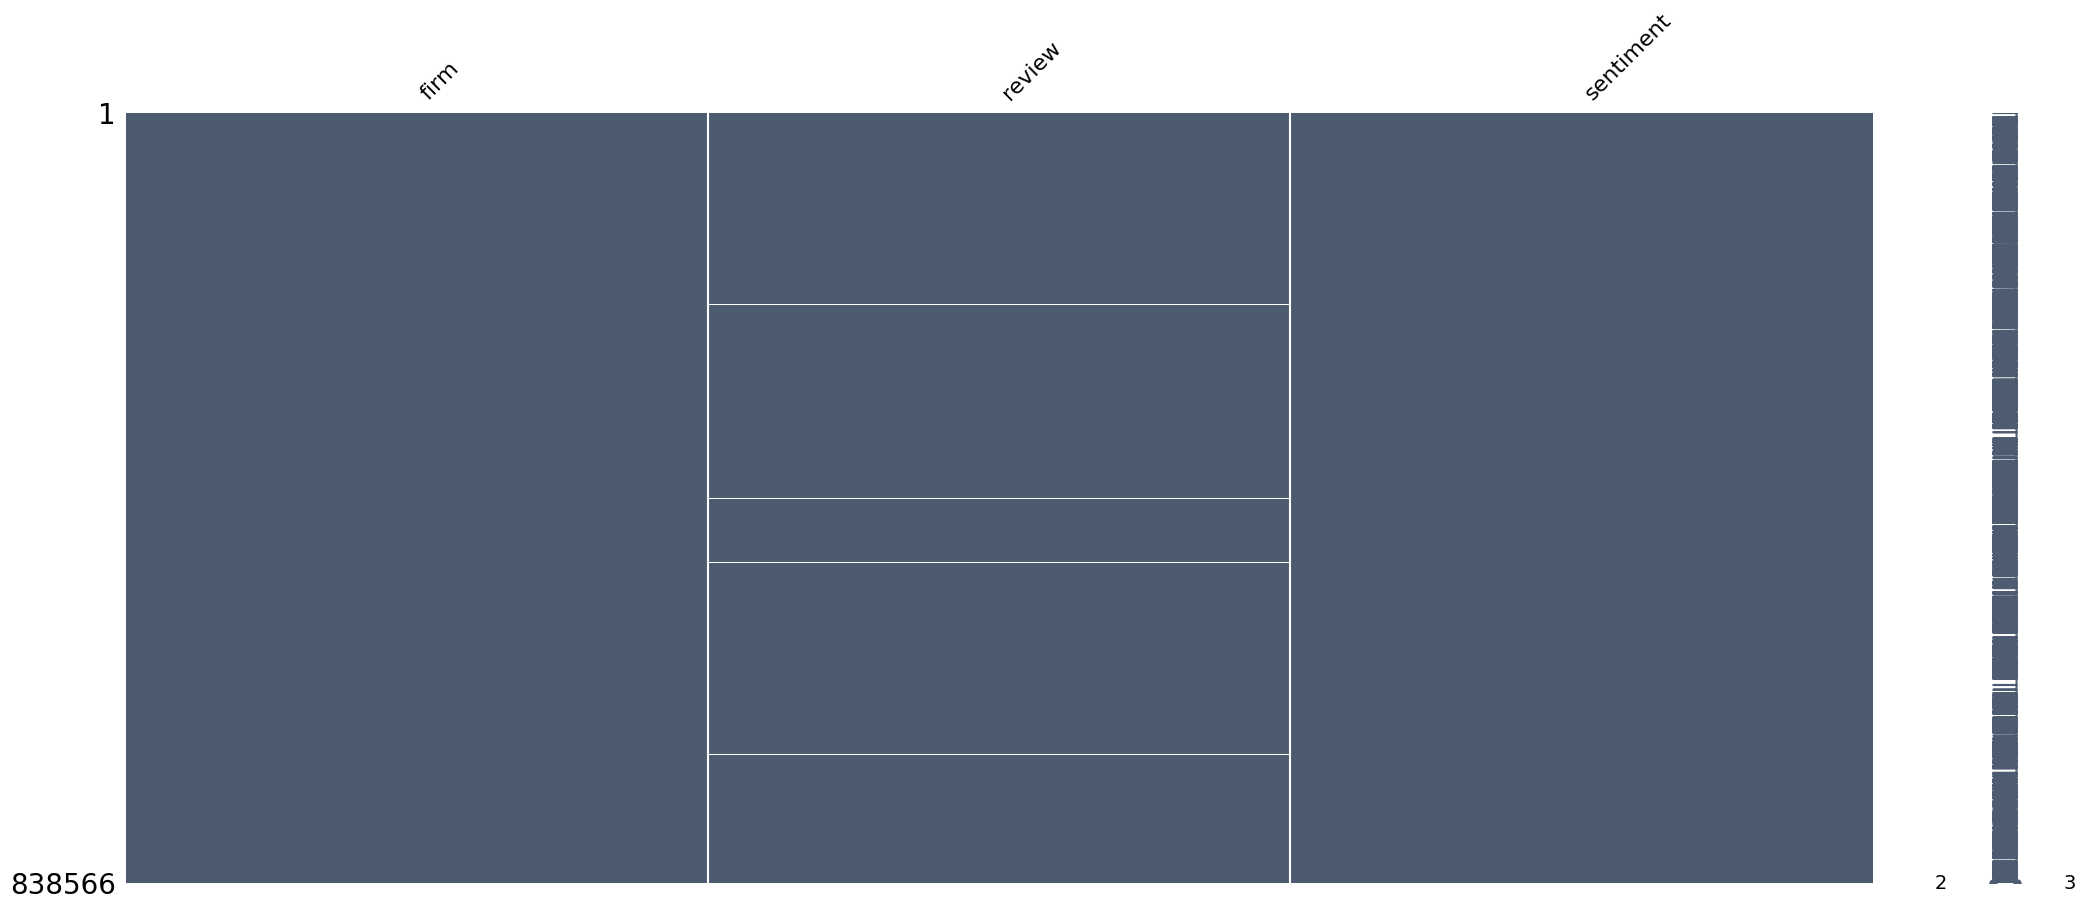

In [ ]:
msno.matrix(data, color=(0.3, 0.36, 0.44))

In [ ]:
data.isna().sum()

,0
firm,0
review,2605
sentiment,0


In [ ]:
data.dropna(subset=['review'], inplace=True)

<Axes: >

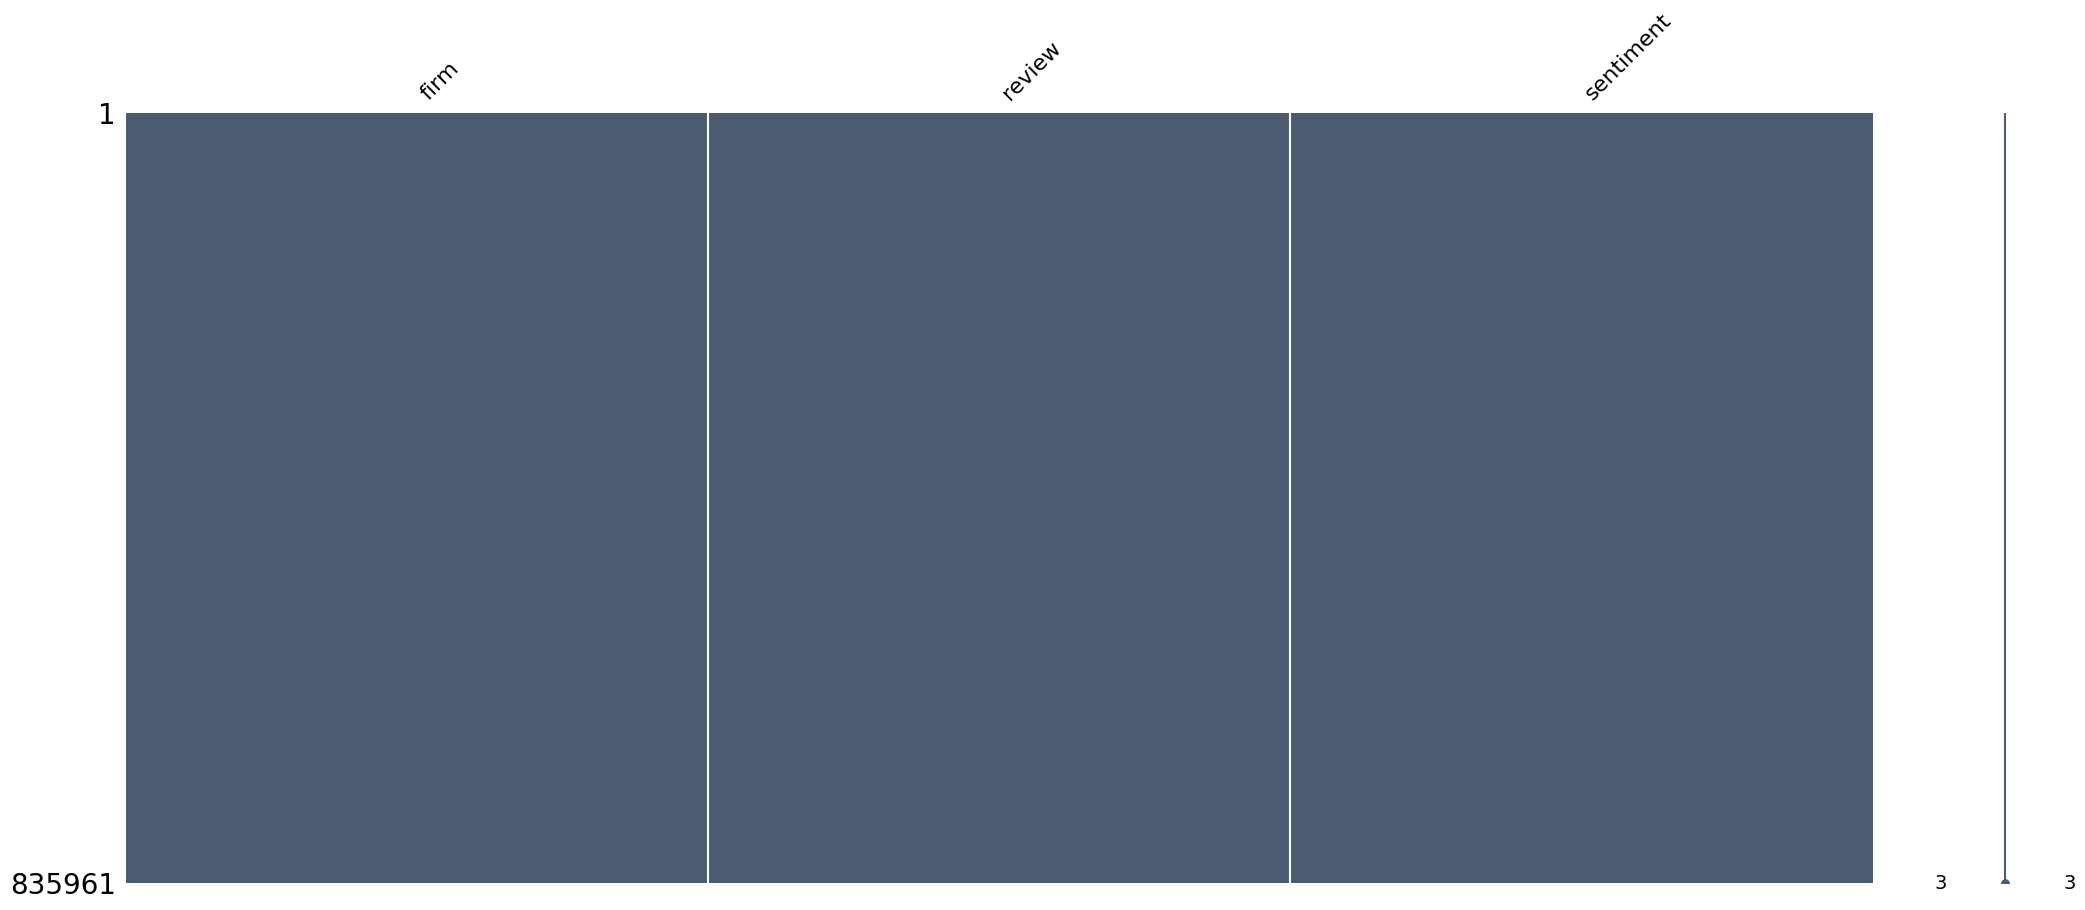

In [ ]:
msno.matrix(data, color=(0.3, 0.36, 0.44))

In [ ]:
data.isna().sum()

,0
firm,0
review,0
sentiment,0


<Axes: xlabel='sentiment', ylabel='count'>

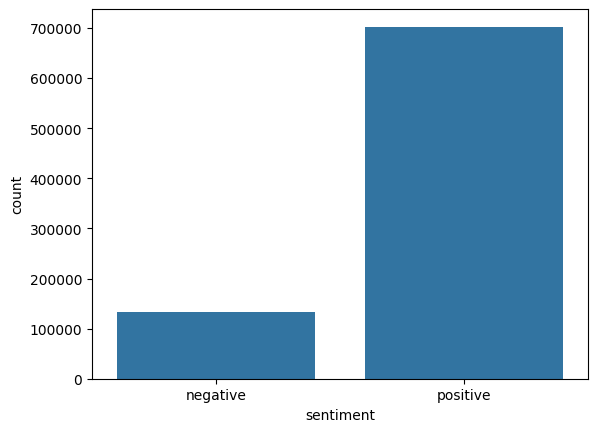

In [ ]:
sns.countplot(x='sentiment', data=data)

<H1>Clearly, the data is unbalanced.</h1>
So we make the distribution of sentiments balanced.

In [ ]:
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
positive,702529
negative,133432


In [ ]:
negative_rows = data[data['sentiment'] == 'negative']
positive_rows = data[data['sentiment'] == 'positive']

random_negative_rows = negative_rows.sample(n=3432, random_state=42)
random_positive_rows = positive_rows.sample(n=572529, random_state=42)

data.drop(random_negative_rows.index, inplace=True)
data.drop(random_positive_rows.index, inplace=True)

In [ ]:
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
negative,130000
positive,130000


<Axes: xlabel='sentiment', ylabel='count'>

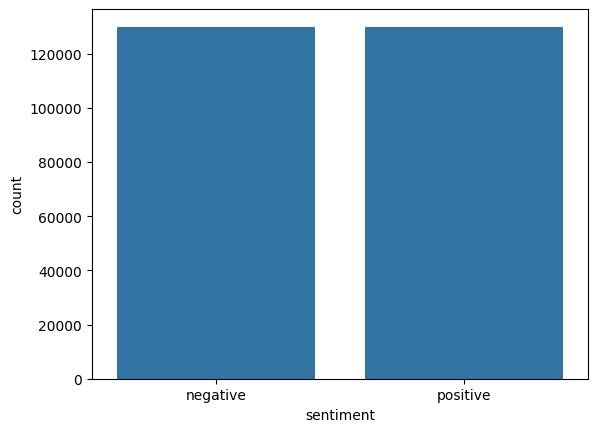

In [ ]:
sns.countplot(x='sentiment', data=data)

<H1>Data Preprocessing</h1>

In [ ]:
data["review"][:10]

,review
0,"Young colleagues, poor micro management. Very ..."
1,"Excellent staff, poor salary. Friendly, helpfu..."
2,"Low salary, bad micromanagement. Easy to get t..."
4,"client reporting admin. Easy to get the job, N..."
6,It horrible management. Good investment manage...
8,"I liked working for AFH. Nice Staff, good HR T..."
9,Honest Review. Made some life time friends.. W...
10,Avoid at all cost. I can't think of any obviou...
11,Worst place I have ever worked. Can do compres...
13,Administration team. Free parking . Meet some ...


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
data['review'] = data['review'].apply(preprocess_text)
data

,firm,review,sentiment
0,AFH-Wealth-Management,young colleagues poor micro management friendl...,negative
1,AFH-Wealth-Management,excellent staff poor salary friendly helpful h...,negative
2,AFH-Wealth-Management,low salary bad micromanagement easy get job ev...,negative
4,AFH-Wealth-Management,client reporting admin easy get job nice colle...,negative
6,AFH-Wealth-Management,horrible management good investment management...,negative
...,...,...,...
838557,the-LEGO-Group,ok work discount lego sets management bad,negative
838558,the-LEGO-Group,great brand family owned great brand danish cu...,positive
838559,the-LEGO-Group,friendly staff members lego staff friendly get...,negative
838560,the-LEGO-Group,awesome place work company clear purpose one t...,positive


Next, we pair phrases that appear together \(collocation\) to form a single word.

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.tokenize import word_tokenize

tokenized_review = data['review'].apply(word_tokenize)

phrases_model_review = Phrases(tokenized_review, min_count=1, threshold=100)

phrases_review = Phraser(phrases_model_review)

collocation_detected_review = list(phrases_review[tokenized_review])

collocation_detected_review = [' '.join(tokens) for tokens in collocation_detected_review]

data['review'] = collocation_detected_review

data

,firm,review,sentiment
0,AFH-Wealth-Management,young colleagues poor micro management friendl...,negative
1,AFH-Wealth-Management,excellent staff poor salary friendly helpful h...,negative
2,AFH-Wealth-Management,low salary bad micromanagement easy get job ev...,negative
4,AFH-Wealth-Management,client reporting admin easy get job nice colle...,negative
6,AFH-Wealth-Management,horrible management good investment management...,negative
...,...,...,...
838557,the-LEGO-Group,ok work discount lego_sets management bad,negative
838558,the-LEGO-Group,great brand family owned great brand danish cu...,positive
838559,the-LEGO-Group,friendly staff members lego staff friendly get...,negative
838560,the-LEGO-Group,awesome place work company clear purpose one t...,positive


In [ ]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(sen)

In [ ]:
X[:5]

['young colleagues poor micro management friendly welcoming new staff easy going ethic poor salaries poor training communication',
 'excellent staff poor salary friendly helpful hard working colleagues poor salary improve much progression incentive work harder high turnover staff poor systems',
 'low salary bad micromanagement easy get job even without experience finance low salary poor working conditions little training provided high expectations micro management young inexperienced superficial girls able provide guidance support teams',
 'client reporting admin easy get job nice colleagues abysmal pay around minimum_wage actual training job role incentive improve training leaves bad taste_mouth ceo drives roll royce majority workers payed lowly',
 'horrible management good investment management strategy overall individual admin staff nice helpful management seniors ruthless training staff staff poorly paid virtually retention consultants communication despite national firm seem under

**<H1>Preparing training and test data</h1>**

In [ ]:
y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**<H1>Preparing Embedding Layer</h1>**

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

59794

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

<H1>Using GloVe for Word Embeddings</h1>
glove.6B.100d.txt contains **6 billion tokens of dimensionality 100**

In [ ]:
embeddings_dictionary = dict()

glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'

response = requests.get(glove_url, stream=True)

with open('glove.6B.zip', 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(59794, 100)

**<h1>Model training with LSTM</h1>**

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(20))
lstm_model.add(Dropout(0.1))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
adam_optimizer = Adam(clipvalue=4.0)
lstm_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       5,979,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,979,400 (22.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,979,400 (22.81 MB)

None


In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Epoch 1/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - acc: 0.7005 - loss: 0.5608 - val_acc: 0.7939 - val_loss: 0.4475
Epoch 2/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - acc: 0.7959 - loss: 0.4430 - val_acc: 0.7986 - val_loss: 0.4321
Epoch 3/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - acc: 0.8023 - loss: 0.4288 - val_acc: 0.8042 - val_loss: 0.4223
Epoch 4/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - acc: 0.8083 - loss: 0.4196 - val_acc: 0.8100 - val_loss: 0.4151
Epoch 5/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - acc: 0.8112 - loss: 0.4097 - val_acc: 0.8053 - val_loss: 0.4188
Epoch 6/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - acc: 0.8113 - loss: 0.4084 - val_acc: 0.8105 - val_loss: 0.4108
Epoch 7/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.8150 - loss: 0.4023 - val_acc: 0.8098 - val_loss: 0.4184
Epoch 8/20
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - acc: 0.8162 - loss: 0.3967 - val_acc: 0.8127 - val_loss: 0.4128
Epoch 9/20
1138/1138 ━━━━━

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

1625/1625 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.8144 - loss: 0.4056


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.40464192628860474
Test Accuracy: 0.8140192031860352


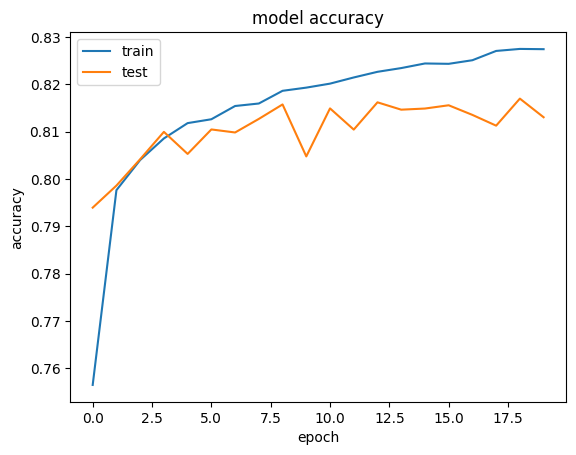

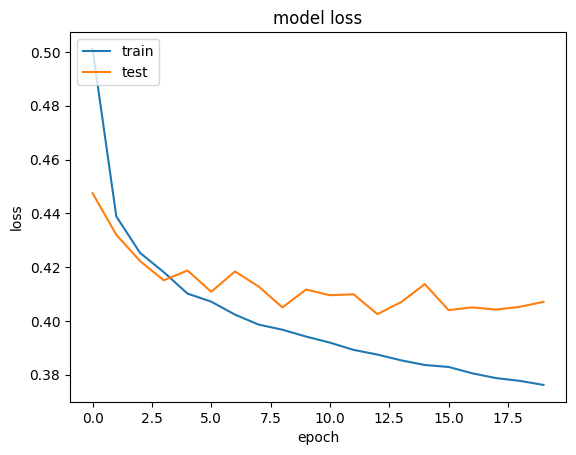

In [ ]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
lstm_model.save("sentiment_LSTM_model.keras")

**<h1>Making Predictions</h1>**

In [ ]:
df = pd.read_csv(path + "/glassdoor_reviews.csv", sep=',', encoding='latin-1')
print("All columns : ");
print(df.columns);
Notkeep = [d for d in df.columns if d not in ['overall_rating','headline','pros','cons','firm']]
print("\nRemoved columns : ");
print(Notkeep);
df    = df.drop(columns=Notkeep)
print("\nSelected columns : ");
print(df.columns);

All columns : 
Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

Removed columns : 
['date_review', 'job_title', 'current', 'location', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv', 'outlook']

Selected columns : 
Index(['firm', 'overall_rating', 'headline', 'pros', 'cons'], dtype='object')


In [ ]:
df['review'] = df['headline']+'. '+df['pros']+'. '+df['cons'];
df.drop(columns=['headline','pros','cons'], inplace=True)
df

,firm,overall_rating,review
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ..."
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu..."
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t..."
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N..."
...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...
838563,the-LEGO-Group,4,not interested in growing their people. loved ...
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l..."


In [ ]:
df.dropna(subset=['review'], inplace=True)

In [ ]:
unseen_reviews = df['review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

26124/26124 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step


array([[0.12393755],
       [0.20585376],
       [0.03685509],
       ...,
       [0.45226133],
       [0.9770768 ],
       [0.98331416]], dtype=float32)

In [ ]:
df['Predicted_Sentiments'] = np.round(unseen_sentiments * 10, 1)
df

,firm,overall_rating,review,Predicted_Sentiments
0,AFH-Wealth-Management,2,"Young colleagues, poor micro management. Very ...",1.2
1,AFH-Wealth-Management,2,"Excellent staff, poor salary. Friendly, helpfu...",2.1
2,AFH-Wealth-Management,1,"Low salary, bad micromanagement. Easy to get t...",0.4
3,AFH-Wealth-Management,5,Over promised under delivered. Nice staff to w...,2.2
4,AFH-Wealth-Management,1,"client reporting admin. Easy to get the job, N...",1.4
...,...,...,...,...
838561,the-LEGO-Group,5,Just an awesome company to work for!!!. Great ...,9.9
838562,the-LEGO-Group,3,working at lego. staff discount is really nice...,2.5
838563,the-LEGO-Group,4,not interested in growing their people. loved ...,4.5
838564,the-LEGO-Group,5,"Great Place to Work. Good wages, good hours, l...",9.8
